In [3]:
%load_ext autoreload
%autoreload 2
import os
import motti
motti.append_current_dir(os.path.abspath(''))

'/home/lupin/Documents/github/prim_diffusion/src'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from model.pipeline_ddpm import DDPMPipelineV2
from model.pipeline_ddim import DDIMPipelineV2
from model.DDPM import DiffusionModel
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler, DDIMPipeline
from PIL import Image

/home/lupin/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
ckpt_dir = "../../ckpt/20241107-084834"
ckpt = torch.load(os.path.join(ckpt_dir, "epoch=98-step=1485.ckpt"), map_location="cpu")

In [20]:
unet_config = UNet2DModel.load_config("../../config/unet.json")
scheduler_config = DDPMScheduler.load_config("../../config/scheduler.json")
unet = UNet2DModel.from_config(unet_config)
scheduler = DDPMScheduler.from_config(scheduler_config)
ddim_scheduler = DDIMScheduler.from_config(scheduler_config)

In [21]:
d = {}
for k, v in ckpt["state_dict"].items():
    if k.startswith("model."):
        d[k[6:]] = v
unet.load_state_dict(d)

<All keys matched successfully>

In [22]:
pipe = DDIMPipelineV2(
    unet=unet,
    scheduler=ddim_scheduler,
)

In [28]:
n = 0
for i in range(25):
    y = pipe(
        batch_size=8, 
        num_inference_steps=50, 
        output_type="numpy",
        mean=1,
        std=0)
    # for img in y.images:
    #     for j in range(4):
    #         x = Image.fromarray((img[..., j] * 255).astype(np.uint8))
    #         x.save(f"../../tmp/img_{n:04d}.png")
    #         n += 1 
    break

100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


In [29]:
import numpy as np

def NMS(img):
    # 在第三个维度上找到每个位置的最大值
    max_values = np.max(img, axis=2, keepdims=True)
    
    # 创建布尔掩码，将不等于最大值的元素置零
    img[img != max_values] = 0
    img[img == max_values] = 1
    return img


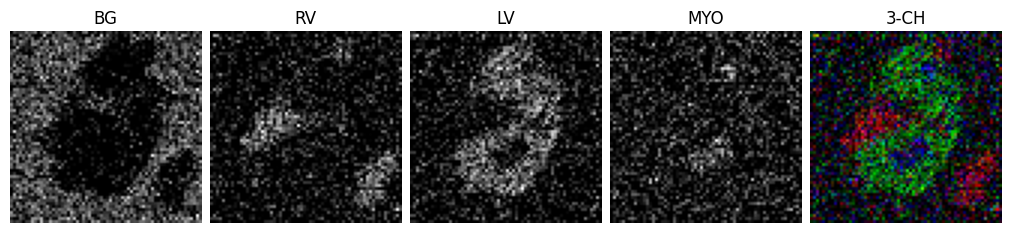

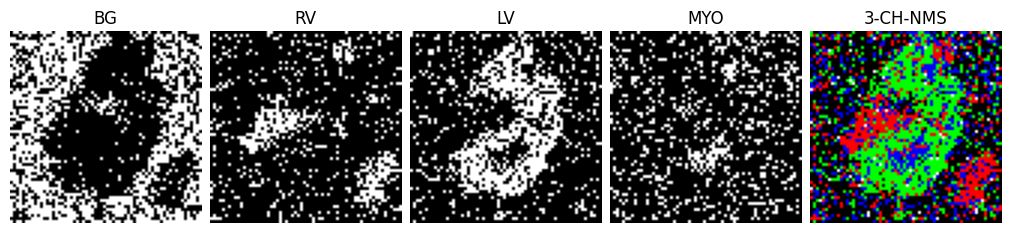

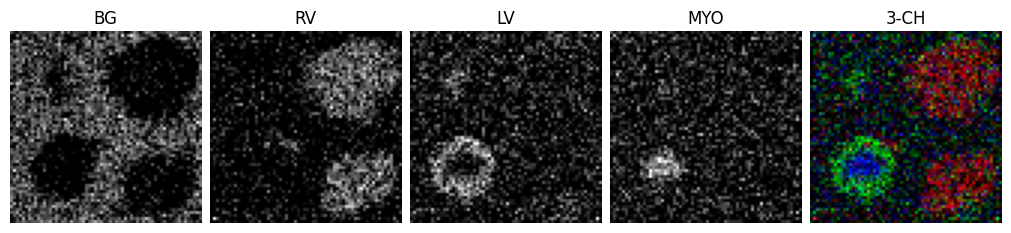

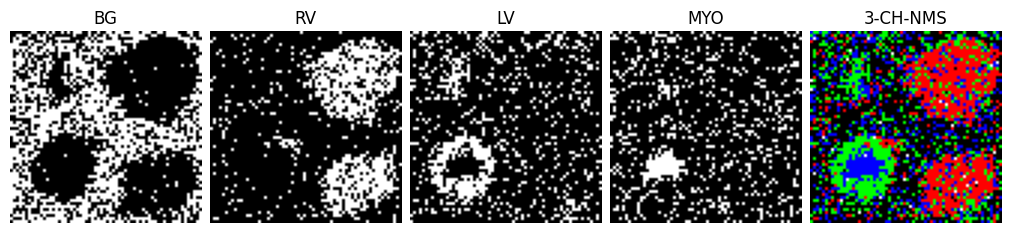

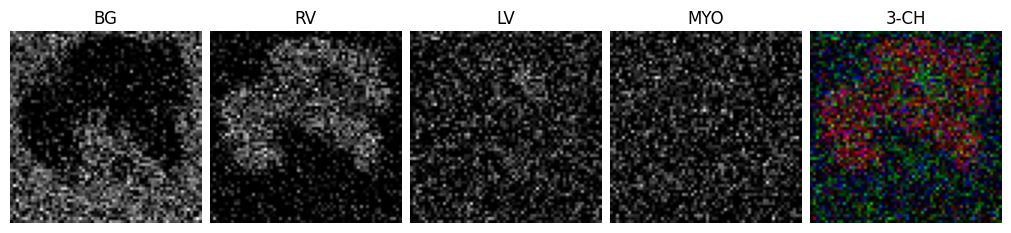

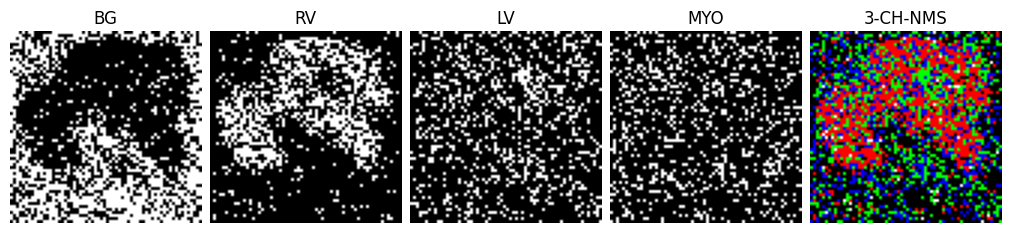

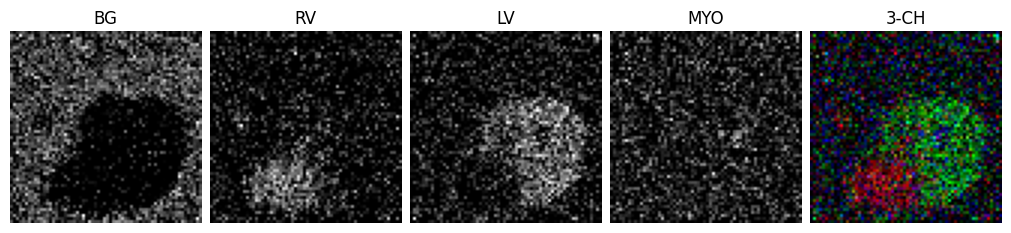

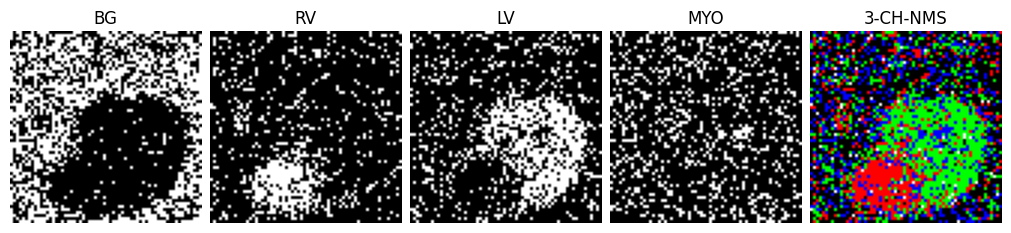

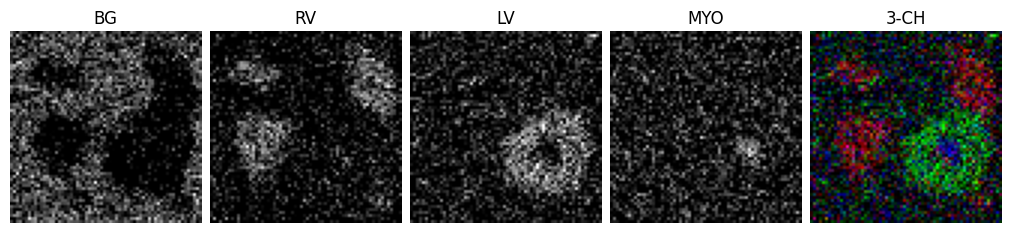

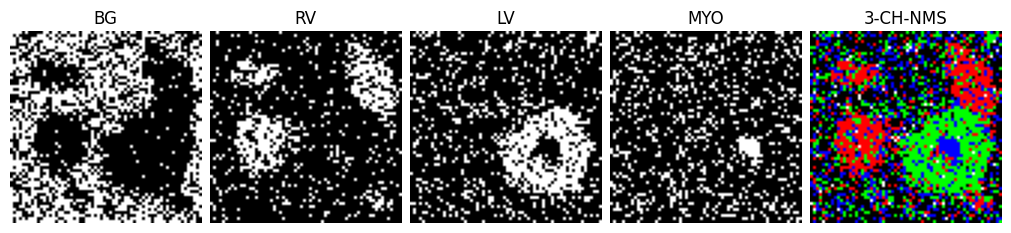

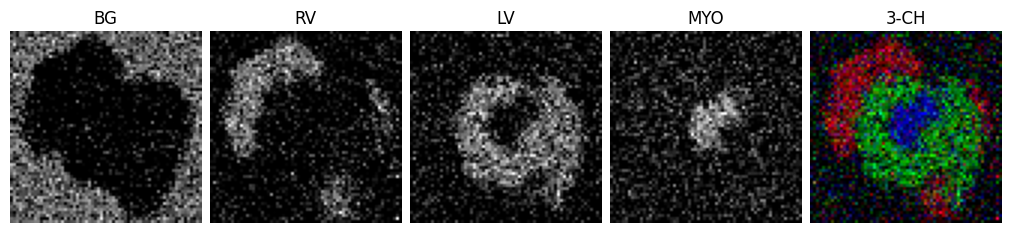

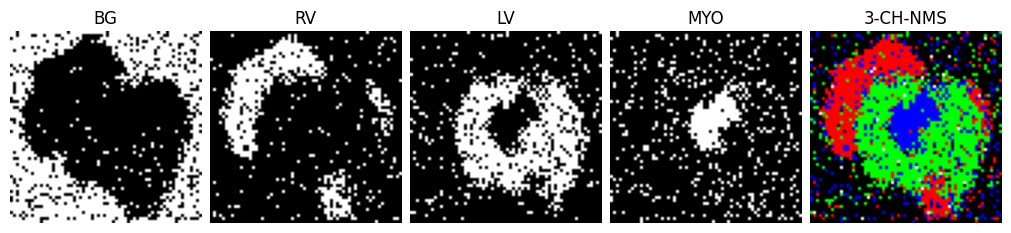

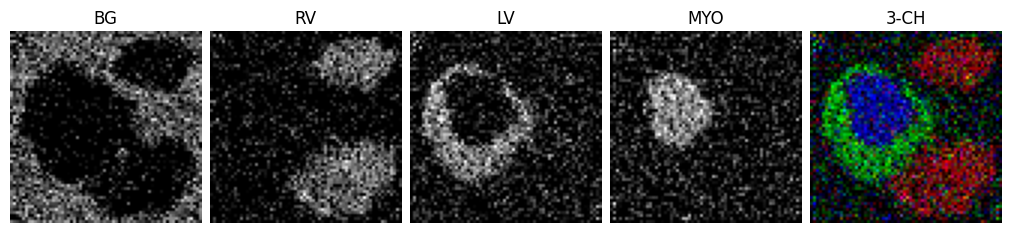

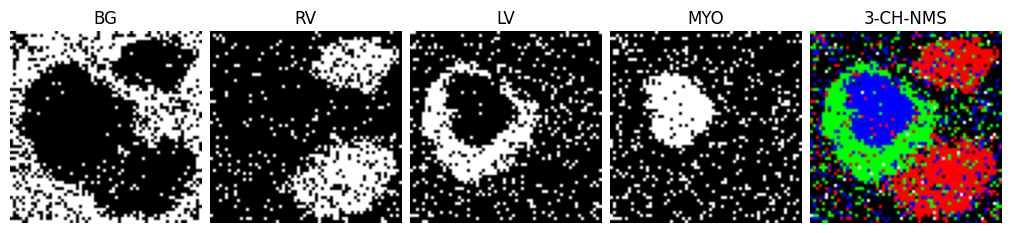

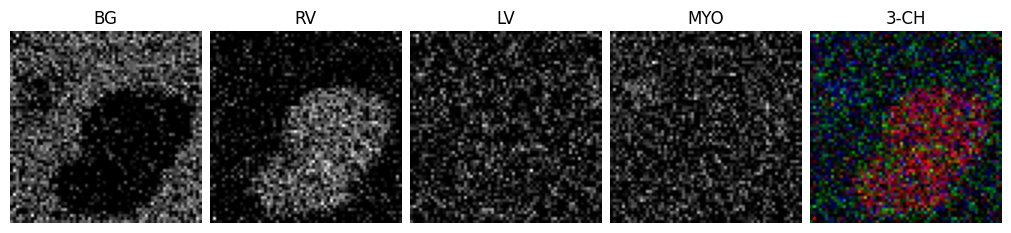

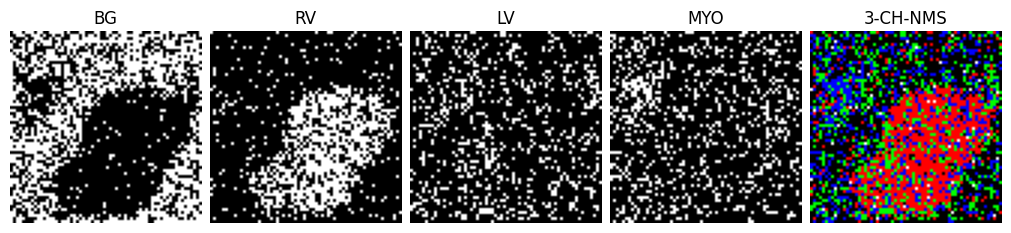

In [30]:
for img in y.images:
    fig, axs = plt.subplots(1, 5, figsize=(10, 3), constrained_layout=True)
    labels = ["BG", "RV", "LV", "MYO", "3-CH"]
    for j in range(4):
        axs[j].imshow(img[..., j], cmap="gray", vmin=0, vmax=1)
    axs[-1].imshow(img[..., 1:])
    
    for j in range(5):
        axs[j].axis("off")
        axs[j].set_title(labels[j])

    fig.savefig(f"../../tmp/{n:03d}.png")
    
    img = NMS(img)
    fig, axs = plt.subplots(1, 5, figsize=(10, 3), constrained_layout=True)
    labels = ["BG", "RV", "LV", "MYO", "3-CH-NMS"]
    for j in range(4):
        axs[j].imshow(img[..., j], cmap="gray", vmin=0, vmax=1)
    axs[-1].imshow(img[..., 1:])
    
    for j in range(5):
        axs[j].axis("off")
        axs[j].set_title(labels[j])

    fig.savefig(f"../../tmp/{n:03d}_nms.png")

    n += 1